## Todo

- try converting these to .tocsr().tocoo()

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import scanpy as sc
import os
remote_atac_dir = '/om2/user/rogerjin/data/NeurIPS2021/multiome/atac'
remote_rna_dir = '/om2/user/rogerjin/data/NeurIPS2021/multiome/rna'
os.makedirs(remote_rna_dir, exist_ok=True)
remote_atac_path = '/om2/user/rogerjin/data/NeurIPS2021/multiome/multiome_atac_processed_training.h5ad'
remote_rna_path = '/om2/user/rogerjin/data/NeurIPS2021/multiome/multiome_gex_processed_training.h5ad'

In [70]:
atac = sc.read_h5ad(remote_atac_path)
rna = sc.read_h5ad(remote_rna_path)
display(atac)
display(rna)

AnnData object with n_obs × n_vars = 42492 × 116490
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'cell_type', 'pseudotime_order_ATAC', 'batch', 'pseudotime_order_GEX', 'is_train'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism', 'sample_pm_varnames'
    obsm: 'gene_activity', 'lsi_full', 'lsi_red', 'umap'
    layers: 'counts'

AnnData object with n_obs × n_vars = 42492 × 13431
    obs: 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'cell_type', 'pseudotime_order_GEX', 'batch', 'pseudotime_order_ATAC', 'is_train'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'dataset_id', 'organism'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
atac_train, atac_val_test, rna_train, rna_val_test = train_test_split(atac, rna, test_size=0.2, random_state=42)
atac_val, atac_test, rna_val, rna_test = train_test_split(atac_val_test, rna_val_test, test_size=0.5, random_state=75)

In [76]:
atac_split = {
    'train': atac_train,
    'val': atac_val,
    'test': atac_test
}

rna_split = {
    'train': rna_train,
    'val': rna_val,
    'test': rna_test
}

In [77]:
for split_name, split in atac_split.items():
    split.write_h5ad(f'{remote_atac_dir}/atac_{split_name}.h5ad')
    
for split_name, split in rna_split.items():
    split.write_h5ad(f'{remote_rna_dir}/rna_{split_name}.h5ad')

In [2]:
atac_split = {
    'train': sc.read_h5ad(f'{remote_atac_dir}/atac_train.h5ad'),
    'val': sc.read_h5ad(f'{remote_atac_dir}/atac_val.h5ad'),
    'test': sc.read_h5ad(f'{remote_atac_dir}/atac_test.h5ad')
}

In [3]:
def var(a, axis=None):
    """ Variance of sparse matrix a
    var = mean(a**2) - mean(a)**2
    source: https://gist.github.com/sumartoyo/edba2eee645457a98fdf046e1b4297e4
    """
    a_squared = a.copy()
    a_squared.data **= 2
    return a_squared.mean(axis) - np.square(a.mean(axis))

var_atac_train = var(atac_split['train'].X, axis=0)
var_atac_train

matrix([[0.00756116, 0.00857404, 0.01617414, ..., 0.00712643, 0.14550444,
         0.01257566]])

In [4]:
sorted_indices = np.fliplr(var_atac_train.argsort())
sorted_indices = np.asarray(sorted_indices).squeeze()
display(var_atac_train[:, sorted_indices])

matrix([[0.24999275, 0.24982592, 0.24817671, ..., 0.0014394 , 0.00141006,
         0.00138073]])

In [5]:
torch.save(torch.tensor(sorted_indices.copy()), f'{remote_atac_dir}/sorted_indices_decreasing_variance.pt')

In [6]:
for split_name, split in atac_split.items():
    split[:, sorted_indices].write_h5ad(f'{remote_atac_dir}/atac_{split_name}_sorted_decreasing_variance.h5ad')

In [8]:
top_512 = sorted_indices.tolist()[:512]

Not sure if this inbalance matters or not.

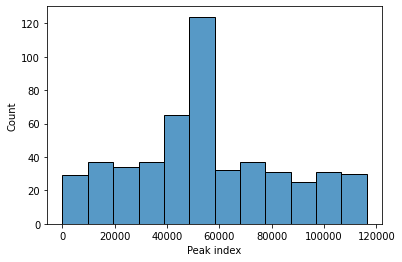

In [15]:
import seaborn as sns

ax = sns.histplot(top_512)
_ = ax.set(xlabel='Peak index')

## Training

In [6]:
import os
import pprint

config = {
    'run_name': 'test-run',
    'batch_size': 32,
    'lr': 5e-4,
    'max_seq_len': 1600,
    'epochs': 1000,
    'use_binary': True,
}

In [5]:
import wandb
try:
    wandb.finish()
except:
    pass
wandb.init(project="Squish Transformer", entity="rogershijin", reinit=True, config=config, name=config.get('run_name', None))
checkpoint_dir = f'/om2/user/rogerjin/checkpoints/{wandb.run.name}'
os.makedirs(checkpoint_dir, exist_ok=True)
wandb.config.update({'checkpoint_dir': checkpoint_dir})
pprint.pprint(dict(wandb.config), indent=2)

{ 'batch_size': 32,
  'checkpoint_dir': '/om2/user/rogerjin/checkpoints/test-run',
  'epochs': 1000,
  'lr': 0.0005,
  'max_seq_len': 1600,
  'run_name': 'test-run',
  'use_binary': True}


In [3]:
import scanpy as sc

atac = {
    'train': sc.read_h5ad(f'{remote_atac_dir}/atac_train_sorted_decreasing_variance.h5ad'),
    'val': sc.read_h5ad(f'{remote_atac_dir}/atac_val_sorted_decreasing_variance.h5ad'),
    'test': sc.read_h5ad(f'{remote_atac_dir}/atac_test_sorted_decreasing_variance.h5ad')
}

rna = {
    'train': sc.read_h5ad(f'{remote_rna_dir}/rna_train.h5ad'),
    'val': sc.read_h5ad(f'{remote_rna_dir}/rna_val.h5ad'),
    'test': sc.read_h5ad(f'{remote_rna_dir}/rna_test.h5ad')
}

In [4]:
from ganoli.GanoliDataset import GanoliMultimodalDataset
from muon import MuData

class MuDataWithLen(MuData):
    
    def __len__(self):
        try:
            return self._len
        except:
            self._len = min(len(mod) for mod in self.mod.values())
            return self._len

datasets = {
    partition: MuDataWithLen({'atac': atac[partition], 'rna': rna[partition]}) for partition in atac.keys()
}
datasets

{'train': MuData object with n_obs × n_vars = 33993 × 129921
   var:	'feature_types'
   2 modalities
     atac:	33993 x 116490
       obs:	'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'cell_type', 'pseudotime_order_ATAC', 'batch', 'pseudotime_order_GEX', 'is_train'
       var:	'feature_types'
       uns:	'dataset_id', 'gene_activity_var_names', 'organism', 'sample_pm_varnames'
       obsm:	'gene_activity', 'lsi_full', 'lsi_red', 'umap'
       layers:	'counts'
     rna:	33993 x 13431
       obs:	'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'cell_type', 'pseudotime_order_GEX', 'batch', 'pseudotime_order_ATAC', 'is_train'
       var:	'gene_ids', 'feature_types', 'genome'
       uns:	'dataset_id', 'organism'
       obsm:	'X_pca', 'X_umap'
       layers:	'counts',
 'val': MuData object with n_obs × n_vars = 4249 × 129921
   var:	'feature_types'
   2 modalities
     atac:	4249 x 116490
       obs:	'nCount_peaks', 'ata

In [7]:
from muon import MuData as md
from torch.utils.data import DataLoader, BatchSampler, SequentialSampler, RandomSampler
torch.manual_seed(42)

samplers = {
    'train': RandomSampler,
    'val': SequentialSampler,
    'test': SequentialSampler
}

# todo: increase val/test batch size

loaders = {
    partition: DataLoader(dataset, sampler=BatchSampler(samplers[partition](dataset), batch_size=config['batch_size'], drop_last=False ), collate_fn=lambda x: x[0]) for partition, dataset in datasets.items()
}

In [18]:
rna['val'].X.todense().var(axis=0).mean()**0.5

0.3085152101624853

In [21]:
rna['val'].X.todense().var()**0.5

0.349474922340714

In [10]:
LOCAL = False
cache_dir=None if LOCAL else "/om2/user/rogerjin/.cache"
print("local" if LOCAL else "remote")

remote


In [4]:
import torch 

try:
    del model
except:
    pass
try:
    del squished
except:
    pass
try:
    del rna
except:
    pass
try:
    del optimizer
except:
    pass
    
torch.cuda.empty_cache()

In [32]:
from transformers import DistilBertModel, DistilBertConfig
from torch.nn import Linear

class SquishTransformer(torch.nn.Module):
    
    def __init__(self, output_dim=13431):
        super().__init__()
        self.output_dim = output_dim
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased', cache_dir=cache_dir)
        self.distilbert.embeddings.word_embeddings = torch.nn.Embedding(116492, 768) # todo: magic numbers
        self.pre_classifier = Linear(self.distilbert.config.dim, self.distilbert.config.dim)
        self.classifier = Linear(self.distilbert.config.dim, output_dim)
        
    def forward(self, **kwargs):
        out = self.distilbert(**kwargs).last_hidden_state[:, 0] # embedding of cls
        out = self.pre_classifier(out)
        out = self.classifier(out)
        return out

model = SquishTransformer()
# device = 'cpu'
device = 'cuda:0'
_ = model.to(device)

TypeError: __init__() got an unexpected keyword argument 'max_position_embeddings'

In [24]:
from squish_indexing import squish_and_embed
from torch.nn import MSELoss
from torch.optim import AdamW
import math
from time import perf_counter

device = 'cuda:0'
loss_fn = MSELoss()
optimizer = AdamW(model.parameters(), lr=config['lr'])

def forward_pass(batch, use_binary=config.get('use_binary', False)):
    if use_binary:
        atac = batch.mod['atac'].X.tocsr().tocoo()
    else:
        atac = batch.mod['atac'].layers['counts'].tocsr().tocoo()
    squished = squish_and_embed(atac, model.distilbert.embeddings.word_embeddings, max_seq_len=config['max_seq_len'])
    out = model(inputs_embeds=squished['embeddings'], attention_mask=squished['attention_mask'])
    return out
    
def train_step(batch):
    optimizer.zero_grad()
    out = forward_pass(batch)
    rna = torch.tensor(batch.mod['rna'].X.todense()).float().to(device)
    loss = loss_fn(out, rna)
    loss.backward()
    optimizer.step()
    return loss.item()

def eval_batch(batch):
    with torch.no_grad():
        out = forward_pass(batch)
        rna = torch.tensor(batch.mod['rna'].X.todense()).float().to(device)
        loss = loss_fn(out, rna)
    return loss.item()

best_checkpoint_path = ''

best_train_loss = math.inf
best_train_loss_epoch = 0

print(f'STARTING INITIAL VALIDATION...')
val_loss = 0
val_start = perf_counter()
for batch in loaders['val']:
    val_loss += eval_batch(batch)
    break
val_end = perf_counter()
print(f'val_loss={val_loss:.5f} time={(val_end - val_start)/3600:.5f}')
print(f'INITIAL VALIDATION COMPLETE\n')
    
best_val_loss = val_loss
best_val_loss_epoch = 0
    
wandb.log({
    'epoch': 0,
    'val/loss': val_loss,
    'val/best_loss': best_val_loss,
    'val/time': (val_end - val_start)/3600
})

print(f'STARTING TRAINING...')
for epoch in range(1, config['epochs']+1):
    train_loss = 0
    val_loss = 0
    
    train_start = perf_counter()
    for batch in loaders['train']:
        train_loss += train_step(batch)
        break
    train_end = perf_counter()
        
    val_start = perf_counter()
    for batch in loaders['val']:
        val_loss += eval_batch(batch)
        break
    val_end = perf_counter()
        
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_train_loss_epoch = epoch
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_loss_epoch = epoch
        print(f'Epoch {epoch}/{config["epochs"]}: New best val loss of {val_loss:.5f}!')
        
        if epoch > 0:
            best_checkpoint_path = f"{wandb.config.checkpoint_dir}/epoch={epoch}-val_loss={val_loss:.5f}.pt" 
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train/loss': train_loss,
                'train/best_loss': best_train_loss,
                'train/best_loss_epoch': best_train_loss_epoch,
                'val/loss': val_loss,
                'val/best_loss': best_val_loss,
                'val/best_loss_epoch': best_val_loss_epoch,
                }, best_checkpoint_path)

            with open(f"{wandb.config.checkpoint_dir}/best_checkpoint_path.txt", 'w') as best_f:
                best_f.write(best_checkpoint_path)
            
            print(f'Saved checkpoint to: {best_checkpoint_path}')
        
    wandb.log({
        'epoch': epoch,
        'train/loss': train_loss, 
        'train/best_loss': best_train_loss,
        'train/best_loss_epoch': best_train_loss_epoch,
        'train/time': (train_end - train_start)/3600,
        'val/loss': val_loss,
        'val/best_loss': best_val_loss,
        'val/best_loss_epoch': best_val_loss_epoch,
        'val/time': (val_end - val_start)/3600,
        'best_checkpoint_path': best_checkpoint_path,
    })
    
    print(f'Epoch {epoch}/{config["epochs"]}: train_loss={train_loss:.5f} best_train_loss={best_train_loss:.5f} best_train_loss_epoch={best_train_loss_epoch} val_loss={val_loss:.5f} best_val_loss={best_val_loss:.5f} best_val_loss_epoch={best_val_loss_epoch} time={(val_end-train_start)/3600:.5f}')
    
    break
    
test_loss = 0
test_start = perf_counter()
for batch in loaders['test']:
    test_loss += eval_batch(batch)
    break
test_end = perf_counter()
    
wandb.log({
    'epoch': epoch,
    'test/loss': test_loss,
    'test/time': (test_end-test_start)/3600
})
print('TRAINING COMPLETE\n')

print('STARTING TESTING...')
print(f'test_loss={test_loss:.5f} time={(test_end-test_start)/3600:.5f}')
print('TESTING COMPLETE')

STARTING INITIAL VALIDATION...
val_loss=0.13541 time=0.00016
INITIAL VALIDATION COMPLETE

STARTING TRAINING...
Epoch 1/1000: New best val loss of 0.12815!
Saved checkpoint to: /om2/user/rogerjin/checkpoints/test-run/epoch=1-val_loss=0.12815.pt
Epoch 1/1000: train_loss=0.14066 best_train_loss=0.14066 best_train_loss_epoch=1 val_loss=0.12815 best_val_loss=0.12815 best_val_loss_epoch=1 time=0.00065
TRAINING COMPLETE

STARTING TESTING...
test_loss=0.13943 time=0.00016
TESTING COMPLETE


In [22]:
class Zero(torch.nn.Module):
    
    def forward(self, batch):
        return 0

In [23]:
model.distilbert.embeddings.position_embeddings = Zero()

In [31]:
model.distilbert.embeddings.position_embeddings.weight

Parameter containing:
tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
          6.8312e-04,  1.5441e-02],
        [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
          2.9753e-02, -5.3247e-03],
        [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
          1.8741e-02, -7.3140e-03],
        ...,
        [ 1.7418e-02,  3.4903e-03, -9.5621e-03,  ...,  2.9599e-03,
          4.3435e-04, -2.6949e-02],
        [ 2.1687e-02, -6.0216e-03,  1.4736e-02,  ..., -5.6118e-03,
         -1.2590e-02, -2.8085e-02],
        [ 2.6413e-03, -2.3298e-02,  5.4922e-03,  ...,  1.7537e-02,
          2.7550e-02, -7.7656e-02]], device='cuda:0', requires_grad=True)

In [13]:
import sys
sys.executable

'/om2/user/rogerjin/conda/ganoli/bin/python'

In [2]:
from transformers import LongT5Model
model = LongT5Model.from_pretrained("google/long-t5-local-base")
model

Some weights of the model checkpoint at google/long-t5-local-base were not used when initializing LongT5Model: ['lm_head.weight']
- This IS expected if you are initializing LongT5Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongT5Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


LongT5Model(
  (shared): Embedding(32128, 768)
  (encoder): LongT5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): LongT5Block(
        (layer): ModuleList(
          (0): LongT5LayerLocalSelfAttention(
            (LocalSelfAttention): LongT5LocalAttention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): LongT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): LongT5LayerFF(
            (DenseReluDense): LongT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bia